**0. Import libraries and data processing**

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Load and preprocess dataset
file_path = 'Ford_truck_sales.csv'  # Update with your file path
truck_sales_data = pd.read_csv(file_path)

# Convert 'Month-Year' to a proper datetime format and set it as the index
truck_sales_data['Month-Year'] = pd.to_datetime(truck_sales_data['Month-Year'], format='%y-%b')
truck_sales_data.set_index('Month-Year', inplace=True)


**1. Visualize and check for trend and seasonality**

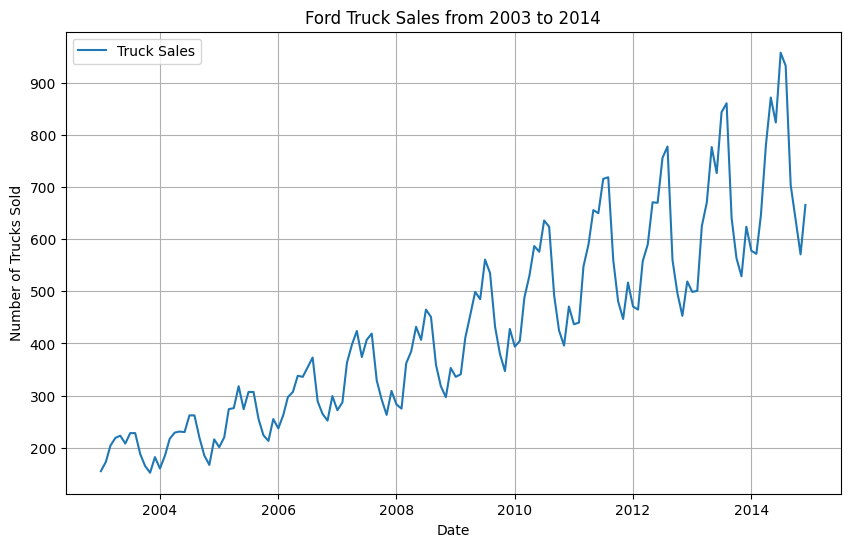

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(truck_sales_data['Number_Trucks_Sold'], label='Truck Sales')
plt.title('Ford Truck Sales from 2003 to 2014')
plt.xlabel('Date')
plt.ylabel('Number of Trucks Sold')
plt.legend()
plt.grid(True)
plt.show()

**2. Check stationarity using the ADF (Augmented Dickey-Fuller) test and apply differencing**

ADF Statistic: 1.1158932574252673
p-value: 0.9953500083802601
Critical Values:
   1%: -3.482087964046026
   5%: -2.8842185101614626
   10%: -2.578864381347275
ADF Statistic: -2.541355326769904
p-value: 0.10573354923819939
Critical Values:
   1%: -3.4825006939887997
   5%: -2.884397984161377
   10%: -2.578960197753906


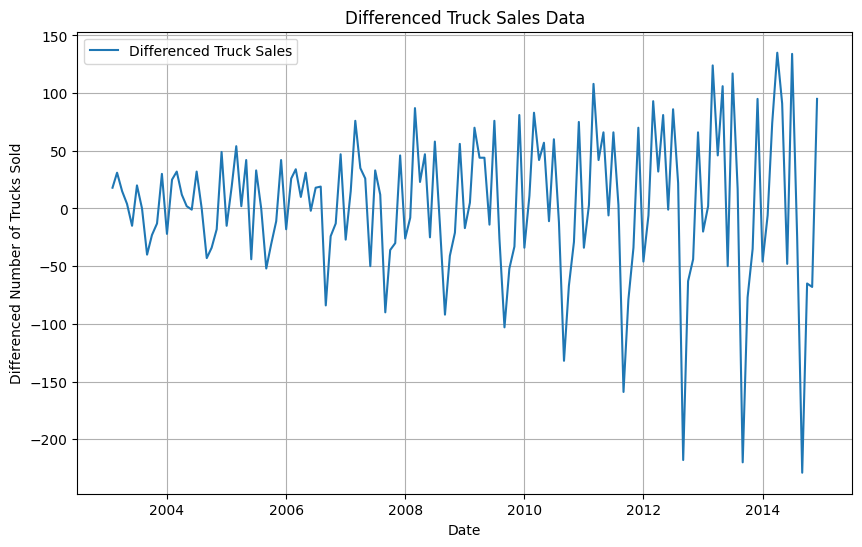

After one differencing, p-value: 0.10573354923819939


In [ ]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1]  # return p-value

# Start by checking the stationarity of the original data
p_value = check_stationarity(truck_sales_data['Number_Trucks_Sold'])

# Apply one differencing step if the p-value is greater than 0.05 (non-stationary)
if p_value > 0.05:
    # Apply first differencing
    truck_sales_diff = truck_sales_data.diff().dropna()

    # Check stationarity again after one differencing step
    p_value_diff = check_stationarity(truck_sales_diff['Number_Trucks_Sold'])

    # Plot the differenced data
    plt.figure(figsize=(10, 6))
    plt.plot(truck_sales_diff, label='Differenced Truck Sales')
    plt.title('Differenced Truck Sales Data')
    plt.xlabel('Date')
    plt.ylabel('Differenced Number of Trucks Sold')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'After one differencing, p-value: {p_value_diff}')
else:
    print(f'No differencing needed, p-value is already less than 0.05: {p_value}')
    truck_sales_diff = truck_sales_data  # Use the original data

**ADF Test**: The Augmented Dickey-Fuller (ADF) test checks for stationarity (i.e., whether the time series has a constant mean and variance over time).
If the p-value is too high (> 0.15) then we need to perform differencing to make the data stationary.

**4. Plot ACF and PACF**

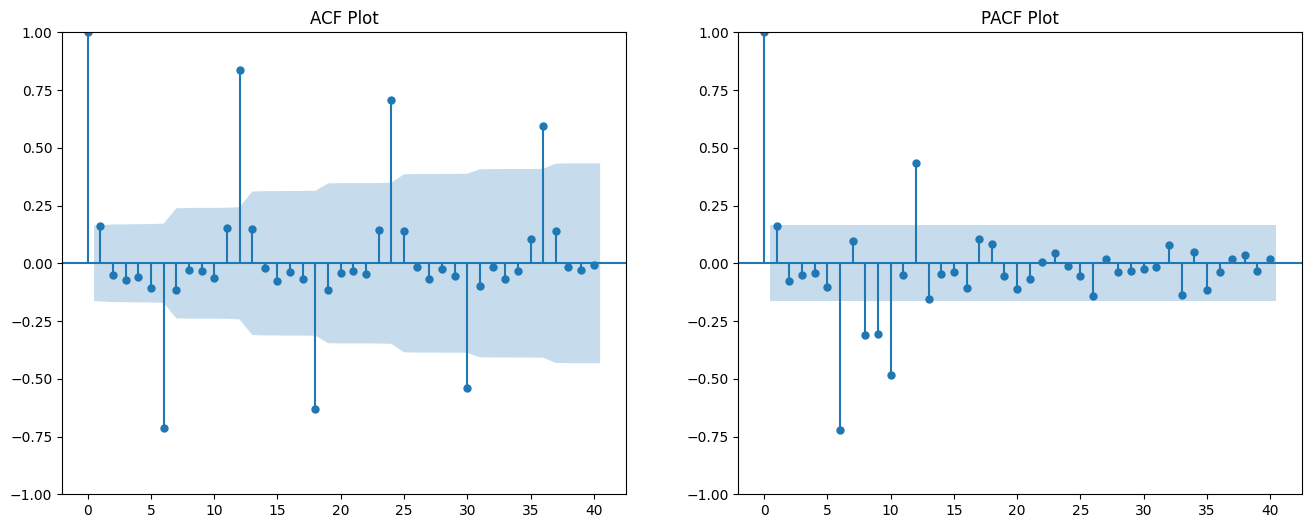

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_acf(truck_sales_diff, lags=40, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(truck_sales_diff, lags=40, ax=plt.gca())
plt.title('PACF Plot')

plt.show()

**ACF (Autocorrelation Function)**:
The ACF plot shows how the current value in the time series is related to its previous values (lags).
In simple terms, it helps us understand how much each value depends on past values.
If the plot shows significant spikes at specific lags (e.g., 1, 2, or 3), it means the past values from those time points are influencing the current value. The ACF plot helps us determine the Moving Average (MA) term, which is the q parameter in SARIMA. This tells us how many previous forecast errors are used in the model.

**PACF (Partial Autocorrelation Function)**:
The PACF plot shows the direct relationship between the current value and its past values, removing the effect of values in between. It shows how much a value is influenced by another value a few steps earlier, after accounting for values in between. If there are significant spikes at certain lags, it indicates that those earlier values directly affect the current one. The PACF plot helps us determine the AutoRegressive (AR) term, which is the p parameter in SARIMA. This tells us how many past values (lags) to include in the model.

**How to Interpret the Plots**: Look at the ACF plot for significant spikes at certain lags. The spikes drop off quickly after lag 1, it suggests an MA(1) model. Similarly, in the PACF plot, there are significant spikes at lag 1, it suggests an AR(1) model.

**5. Split the training and test dataset**

In [ ]:
train_size = int(len(truck_sales_data) * 0.90)
train_data = truck_sales_data.iloc[:train_size]
test_data = truck_sales_data.iloc[train_size:]

**6. Fit the SARIMA model using the parameter that we got from ACF and PACF analysis**

In [ ]:
sarima_model = SARIMAX(train_data['Number_Trucks_Sold'],
                       order=(1, 1, 1),  # Non-seasonal (p, d, q)
                       seasonal_order=(1, 1, 1, 12),  # Seasonal (P, D, Q, s)
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**7. Forecast and validate the model**

In [ ]:
# Forecast for the test period
forecast_test = sarima_fit.get_forecast(steps=len(test_data))
forecast_test_values = forecast_test.predicted_mean

# Calculate accuracy metrics: MAE and RMSE
mae = mean_absolute_error(test_data['Number_Trucks_Sold'], forecast_test_values)
rmse = np.sqrt(mean_squared_error(test_data['Number_Trucks_Sold'], forecast_test_values))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 19.95885301908104
Root Mean Squared Error (RMSE): 25.045545500431555


The model evaluation yielded the following results on the test set:

*   **Mean Absolute Error (MAE)**: 19.95
*   **Root Mean Squared Error (RMSE)**: 25.04

These metrics suggest that, on average, the model's predictions are off by around 20 units of truck sales. The RMSE, which gives more weight to larger errors, indicates an error magnitude of approximately 25 units.

**8. Plot the observed VS the forecasted values**

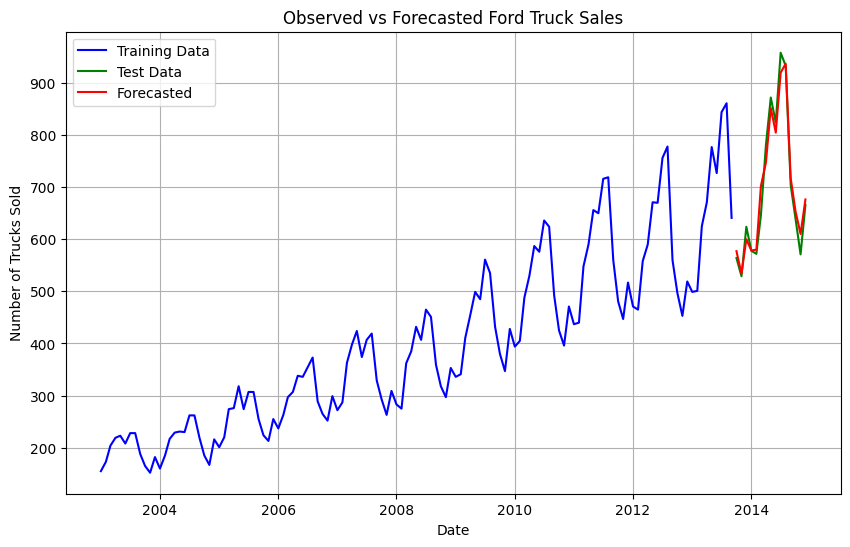

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Number_Trucks_Sold'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Number_Trucks_Sold'], label='Test Data', color='green')
plt.plot(test_data.index, forecast_test_values, label='Forecasted', color='red')
plt.title('Observed vs Forecasted Ford Truck Sales')
plt.xlabel('Date')
plt.ylabel('Number of Trucks Sold')
plt.legend()
plt.grid(True)
plt.show()

**9. Forecast future values**

In [ ]:
# Forecast future values for 2015 (next 12 months)
forecast_future = sarima_fit.get_forecast(steps=12)

# Extract predicted mean and confidence intervals
forecast_future_values = forecast_future.predicted_mean
forecast_conf_int = forecast_future.conf_int()

# Generate index for 2015 (12 months ahead)
forecast_index = pd.date_range(start='2015-01-01', periods=12, freq='MS')

# Correct the column names for confidence intervals
# The first column is the lower bound, and the second is the upper bound.
forecast_conf_int.columns = ['Lower_Bound', 'Upper_Bound']

# Create a table of forecasted values for 2015
forecast_2015_df = pd.DataFrame({
    'Month': forecast_index.strftime('%Y-%m'),
    'Predicted_Sales': forecast_future_values,
    'Lower_Bound': forecast_conf_int['Lower_Bound'],
    'Upper_Bound': forecast_conf_int['Upper_Bound']
})

# Display the forecast table for 2015
print("\nForecasted Truck Sales for 2015:")
print(forecast_2015_df)


Forecasted Truck Sales for 2015:
              Month  Predicted_Sales  Lower_Bound  Upper_Bound
2013-10-01  2015-01       577.219725   542.360787   612.078664
2013-11-01  2015-02       533.773411   489.830942   577.715880
2013-12-01  2015-03       600.088193   546.330978   653.845408
2014-01-01  2015-04       578.488289   517.513094   639.463483
2014-02-01  2015-05       580.037127   512.119030   647.955223
2014-03-01  2015-06       702.147982   628.169968   776.125996
2014-04-01  2015-07       747.315724   667.624230   827.007218
2014-05-01  2015-08       851.696769   766.730378   936.663160
2014-06-01  2015-09       804.733295   714.773652   894.692938
2014-07-01  2015-10       919.723804   825.047298  1014.400311
2014-08-01  2015-11       936.961225   837.785285  1036.137166
2014-09-01  2015-12       717.312945   613.836349   820.789541


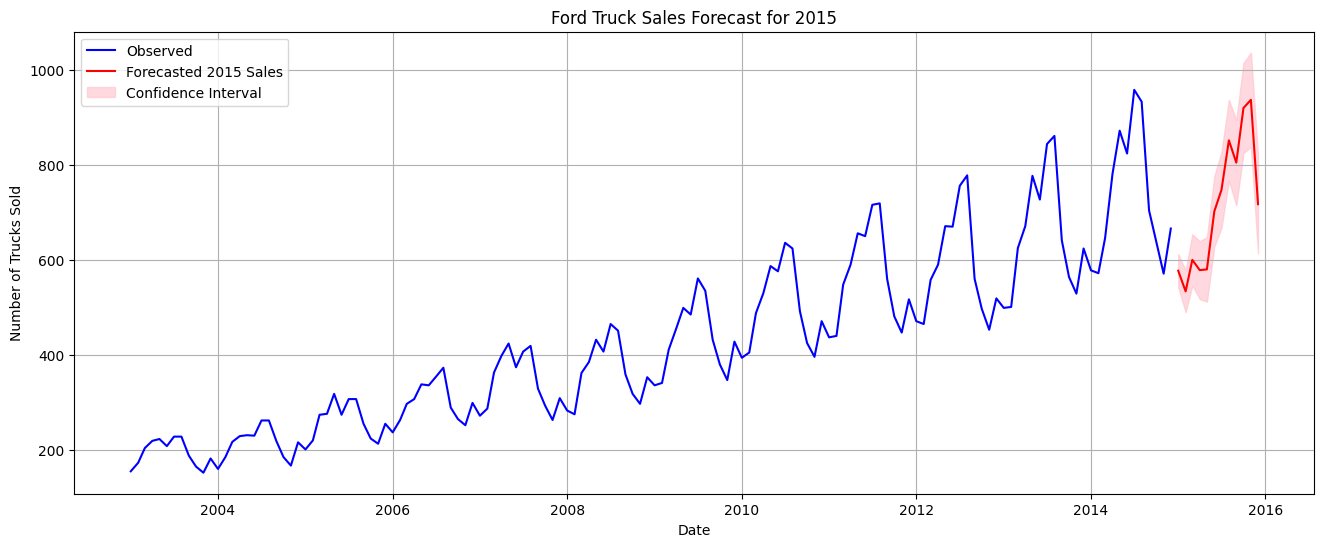

In [ ]:
# Plot forecast for 2015
plt.figure(figsize=(16, 6))
plt.plot(truck_sales_data['Number_Trucks_Sold'], label='Observed', color='blue')
plt.plot(forecast_index, forecast_future_values, label='Forecasted 2015 Sales', color='red')
plt.fill_between(forecast_index,
                 forecast_conf_int['Lower_Bound'],
                 forecast_conf_int['Upper_Bound'],
                 color='pink', alpha=0.6, label='Confidence Interval')
plt.title('Ford Truck Sales Forecast for 2015')
plt.xlabel('Date')
plt.ylabel('Number of Trucks Sold')
plt.legend()
plt.grid(True)
plt.show()